## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Physics-informed MultiONet

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Darcy_Flow_pwc2d'
tag = 'fdm_TS'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/pwc_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/pwc_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    a[a==1.] = 10.; a[a==0.] = 5.;
    u = np2tensor(np.array(data["sol_fem"][...,n0:n0+ndata]).T, dtype)
    #
    try:
        X, Y = np.array(data['X_sol']).T, np.array(data['Y_sol']).T
        mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
        gridx = mesh.reshape(-1, 2)
    except:
        X, Y = np.array(data['X']).T, np.array(data['Y']).T
        mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
        gridx = mesh.reshape(-1, 2)
    #
    x = gridx.repeat((ndata, 1, 1))
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    
    return a, u, x, gridx
#
a_train, u_train, x_train, grid_train = get_data(data_train, n_train, dtype)
a_test, u_test, x_test, grid_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of grid_train:', grid_train.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of grid_test:', grid_test.shape)
######################################
# Generate mesh grids for calculating gradients
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_mesh = 29
x_mesh = pointGen.inner_point(N_mesh, method='mesh')
print('x_mesh shape:', x_mesh.shape)

<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of u_train: torch.Size([1000, 841, 1])
The shape of grid_train: torch.Size([841, 2])
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of grid_test: torch.Size([841, 2])
x_mesh shape: torch.Size([841, 2])


### (3.2) Define the loss class and train the model 

In [2]:
###############################
# Define Loss Class
###############################
from Utils.Grad import *
import torch.nn as nn
from torch.autograd import grad, Variable

########################################
class fun_a(object):

    def __init__(self, res):
        super(fun_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x, a):
        a = a.squeeze(-1)
        x_loc = torch.floor(x[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        img = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return img.unsqueeze(-1)

###############################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        xx, yy = x[...,0:1], x[...,1:2]
        u = u * torch.sin(np.pi * xx)*torch.sin(np.pi * yy) 

        return u
        
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.fun_a = fun_a(res=res)
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        #
        self.deltax = 1/(N_mesh-1)
        self.deltay = 1/(N_mesh-1)

    def Loss_pde(self, a_batch, w_pde):
        n_batch = a_batch.shape[0]
        if w_pde>0.:
            a = self.fun_a(x_mesh, a_batch)
            x = Variable(x_mesh.repeat(n_batch, 1, 1).to(self.device), requires_grad=True)
            u = self.model_u(x, self.model_enc(a_batch))
            u = self.mollifer(u, x).reshape(-1, N_mesh, N_mesh, 1)
            a = a.reshape(-1, N_mesh, N_mesh, 1)
            dudx, dudy = FDM_2d(u, self.deltax, self.deltay) 
            adux = a[:,1:-1,1:-1,0:1] * dudx 
            aduy = a[:,1:-1,1:-1,0:1] * dudy 
            dauxdx, _ = FDM_2d(adux, self.deltax, self.deltay) 
            _, dauydy = FDM_2d(aduy, self.deltax, self.deltay) 
            #############################################
            left = (- (dauxdx + dauydy)).reshape(n_batch, -1)
            right = 10. * torch.ones_like(left)

            return self.solver.getLoss(left, right)
        else:
            return torch.tensor(0.)

    def Loss_data(self, x, a, u, w_data):
        return torch.tensor(0.)

    def Error(self, x, a, u):
        u_pred = self.model_u(x, self.model_enc(a))
        u_pred = self.mollifer(u_pred, x)
            
        return self.solver.getError(u_pred, u)

######################################
# Steups of the model
######################################
from Solvers.PIMultiONet import PIMultiONet
solver = PIMultiONet.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch'

####################################### The BranchNet
from Networks.EncoderNet import EncoderCNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv='SiLU', activation_fc='SiLU',
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, x):
        '''
        Input:
            x: size(?, ny*nx, 1)
        Return:
            output: size(?, out_size)
        '''
        x = self.conv(x)
        return x

conv_arch = [1, 32, 64, 64]
fc_arch = [64*2*2, 128]
model_enc = Encoder(conv_arch, fc_arch, nx_size=res, ny_size=res, dtype=dtype).to(device)

###################################### The u model (MultiONet )
hidden_list, act_x, act_a = [128]*3, 'ReLU', 'SiLU'
model_u = solver.getModel(x_in_size=2, a_in_size=fc_arch[-1], hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)

##################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

88,640 training parameters.
115,974 training parameters.
204,614 total parameters


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR',
                   gamma=0.6, step_size=200)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0., w_pde=1., batch_size=50, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/PI{netType}_{tag}/'})

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  5%|████                                                                            | 51/1000 [00:08<02:15,  7.03it/s]

Epoch:50 Time:7.9174, loss:103.8999, loss_pde:103.8999, loss_data:0.0000
                l2_test:0.2545, lr:0.001


 10%|███████▉                                                                       | 101/1000 [00:15<02:07,  7.03it/s]

Epoch:100 Time:15.0344, loss:99.1952, loss_pde:99.1952, loss_data:0.0000
                l2_test:0.2136, lr:0.001


 15%|███████████▉                                                                   | 151/1000 [00:22<02:07,  6.64it/s]

Epoch:150 Time:22.2392, loss:94.8849, loss_pde:94.8849, loss_data:0.0000
                l2_test:0.2159, lr:0.001


 20%|███████████████▉                                                               | 201/1000 [00:29<02:00,  6.63it/s]

Epoch:200 Time:29.7868, loss:92.7963, loss_pde:92.7963, loss_data:0.0000
                l2_test:0.2058, lr:0.0006


 25%|███████████████████▊                                                           | 251/1000 [00:37<01:47,  6.99it/s]

Epoch:250 Time:37.0003, loss:88.7417, loss_pde:88.7417, loss_data:0.0000
                l2_test:0.1775, lr:0.0006


 30%|███████████████████████▊                                                       | 301/1000 [00:44<01:40,  6.97it/s]

Epoch:300 Time:44.1910, loss:88.1806, loss_pde:88.1806, loss_data:0.0000
                l2_test:0.1596, lr:0.0006


 35%|███████████████████████████▋                                                   | 351/1000 [00:51<01:33,  6.97it/s]

Epoch:350 Time:51.3663, loss:86.8806, loss_pde:86.8806, loss_data:0.0000
                l2_test:0.1967, lr:0.0006


 40%|███████████████████████████████▋                                               | 401/1000 [00:58<01:26,  6.93it/s]

Epoch:400 Time:58.5736, loss:86.4700, loss_pde:86.4700, loss_data:0.0000
                l2_test:0.1344, lr:0.00035999999999999997


 45%|███████████████████████████████████▋                                           | 451/1000 [01:05<01:18,  6.96it/s]

Epoch:450 Time:65.7523, loss:83.1963, loss_pde:83.1963, loss_data:0.0000
                l2_test:0.1541, lr:0.00035999999999999997


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:13<01:11,  6.94it/s]

Epoch:500 Time:72.9355, loss:82.5928, loss_pde:82.5928, loss_data:0.0000
                l2_test:0.1511, lr:0.00035999999999999997


 55%|███████████████████████████████████████████▌                                   | 551/1000 [01:20<01:04,  6.95it/s]

Epoch:550 Time:80.1268, loss:81.5276, loss_pde:81.5276, loss_data:0.0000
                l2_test:0.1324, lr:0.00035999999999999997


 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:27<00:57,  6.93it/s]

Epoch:600 Time:87.3265, loss:81.0296, loss_pde:81.0296, loss_data:0.0000
                l2_test:0.1370, lr:0.00021599999999999996


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [01:34<00:50,  6.93it/s]

Epoch:650 Time:94.5380, loss:80.1031, loss_pde:80.1031, loss_data:0.0000
                l2_test:0.1447, lr:0.00021599999999999996


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [01:41<00:43,  6.93it/s]

Epoch:700 Time:101.7506, loss:79.3924, loss_pde:79.3924, loss_data:0.0000
                l2_test:0.1474, lr:0.00021599999999999996


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [01:49<00:35,  6.93it/s]

Epoch:750 Time:108.9656, loss:79.0314, loss_pde:79.0314, loss_data:0.0000
                l2_test:0.1526, lr:0.00021599999999999996


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:56<00:28,  6.92it/s]

Epoch:800 Time:116.1890, loss:78.8592, loss_pde:78.8592, loss_data:0.0000
                l2_test:0.1521, lr:0.00012959999999999998


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [02:03<00:21,  6.91it/s]

Epoch:850 Time:123.4304, loss:77.8268, loss_pde:77.8268, loss_data:0.0000
                l2_test:0.1372, lr:0.00012959999999999998


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:10<00:14,  6.90it/s]

Epoch:900 Time:130.6758, loss:77.6910, loss_pde:77.6910, loss_data:0.0000
                l2_test:0.1403, lr:0.00012959999999999998


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [02:18<00:07,  6.90it/s]

Epoch:950 Time:137.9175, loss:77.5138, loss_pde:77.5138, loss_data:0.0000
                l2_test:0.1361, lr:0.00012959999999999998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.89it/s]

Epoch:1000 Time:145.1634, loss:77.2360, loss_pde:77.2360, loss_data:0.0000
                l2_test:0.1408, lr:7.775999999999999e-05
The total training time is 145.1706


### (3.3) load saved model and make prediction

The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1]) u_pred shape torch.Size([200, 841, 1])
The test loss (avg): tensor(0.2267)
The test l2 error (avg): tensor(0.1408)


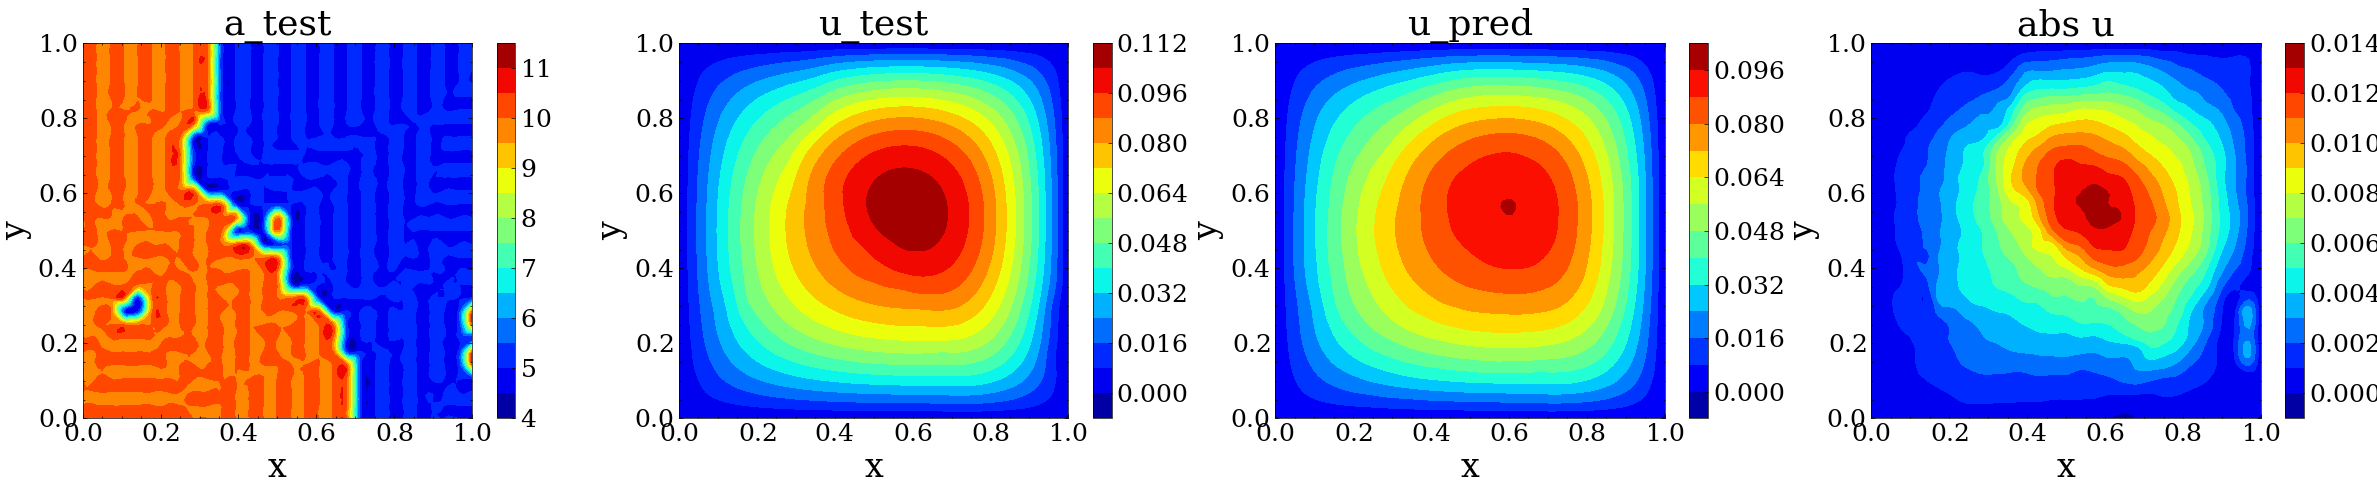

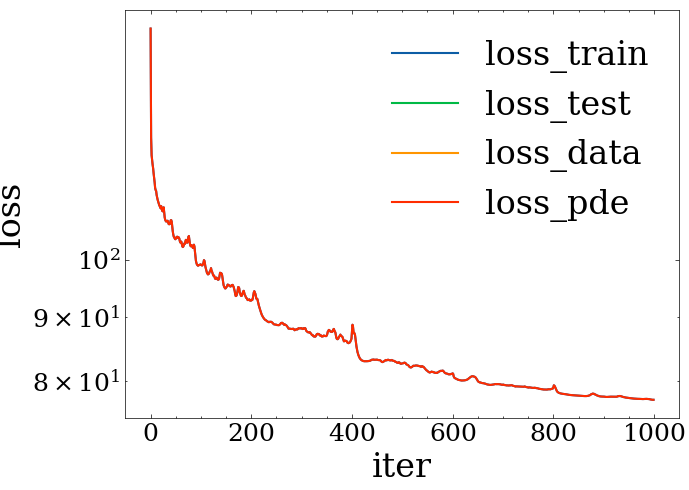

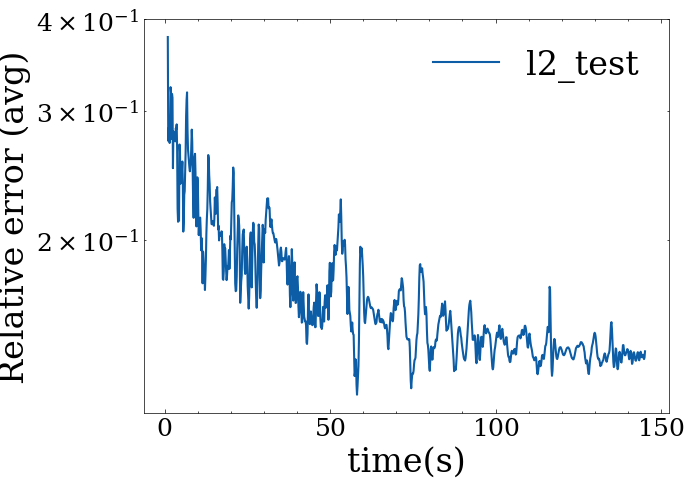

In [3]:
# #######################################
# # Load the trained model
# #######################################
from Solvers.PIMultiONet import PIMultiONet
solver = PIMultiONet.Solver(device=device, dtype=dtype)
tag = 'fdm_TS'
model_trained = solver.loadModel(path=f'saved_models/PI{netType}_{tag}/', name=f'model_pimultionet_final')

#########################################
x_var = Variable(x_test, requires_grad=True).to(device)
try:
    a_var = model_trained['enc'](a_test.to(device))
except:
    a_var = a_test.to(device)
u_pred = model_trained['u'](x_var, a_var)
u_pred = mollifer()(u_pred, x_var).detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape, 'u_pred shape', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([grid_train]+[grid_test]*3, [a_test[inx], u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  ['a_test', 'u_test', 'u_pred', 'abs u'], lb =0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/PI{netType}_{tag}/', name='loss_pimultionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])